In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import pandas as pd
from statistics import mean
from random import choice
%matplotlib inline
import matplotlib.pyplot as plt

from gendis.genetic import GeneticExtractor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tools.data_extraction import DataExtractor
from tools.trajectory_generator import TrajectoryGenerator
from tools.utils import standardize_data, print_genetic_param, print_settings, set_movements, angle_diff,scale_down, get_distance
from tools.experiments import Experiments

np.random.seed(1337)  # Random seed for reproducibility

tr_gen_options = {"samples": 25,
                  "freq": 3,
                  "reset_data": True}
dt_gen_options = {"n_test": 10}

train_test_options = {"split": 25}

df_csv_options = {"ts_class": "Bearing"}

gen_options = {"population_size": 20,
               "iterations": 4,
               "verbose": True,
               "normed": True,
               "add_noise_prob": 0.0,
               "add_shapelet_prob": 0.3,
               "wait": 10,
               "plot": True,
               "remove_shapelet_prob": 0.3,
               "crossover_prob": 0.66,
               "n_jobs": 4}

settings = {"trajectory_generator_options": tr_gen_options,
            "data_generation_options": dt_gen_options,
            "train_test_options":train_test_options,
            "define_csvs_option": df_csv_options,
            "genetic_options": gen_options}

tr_gen_options = settings["trajectory_generator_options"]
dt_gen_options = settings["data_generation_options"]
df_csvs_options = settings["define_csvs_option"]
train_test_options = settings["train_test_options"]
genetic_options = settings["genetic_options"]

first_movement = ['creeping_line_left']
second_movement = ['random']
movements = {'first_movement': first_movement,'second_movement': second_movement}
set_movements(movements)


In [2]:
# Create files if not created
tr_gen = TrajectoryGenerator(**tr_gen_options)
tr_gen.data_generation(**dt_gen_options)
# Read in the datafiles
dex = DataExtractor()
train_df, test_df = dex.train_test_dataframes(**train_test_options)
print("The train samples length is:{0}".format(len(train_df[0] * train_test_options["split"]*2)))
print("The test samples length is:{0}\n".format(len(test_df[0] * train_test_options["split"]*2)))
dex.define_csv(**df_csvs_options)

x_train, y_train, x_test, y_test = dex.load_datasets()

2019-06-07 13:52:46.334 | INFO     | tools.trajectory_generator:data_generation:623 - 
 Starting the generator with attributes: 
Original latitude: 37.295493
Original longitude: 23.824322
Initial bearing: 90
Initial speed: 10
Number of samples: 25
Starting time of measurements: 2015-02-01 12:00:00
With initial frequency of collected data: 3 min
and hard reset of data: True
2019-06-07 13:52:46.336 | INFO     | tools.trajectory_generator:data_generation:626 - Create directory 'generator_data' 
2019-06-07 13:52:46.339 | INFO     | tools.trajectory_generator:data_generation:632 - now creating data for movement: creeping_line_left
2019-06-07 13:52:46.952 | INFO     | tools.trajectory_generator:data_generation:637 - now creating data for movement: random
2019-06-07 13:52:48.981 | SUCCESS  | tools.trajectory_generator:data_generation:670 - Done with generator
2019-06-07 13:52:48.983 | INFO     | tools.data_extraction:read_datasets:22 - Reading the data files
2019-06-07 13:52:49.049 | SUCCESS 

The train samples length is:400
The test samples length is:100



In [3]:
# x_train, y_train, x_test, y_test = dex.load_datasets()
# labels = ["TIMESTAMP","LAT","LON","HEADING"]
# real_data =  pd.read_csv("/home/kapadais/Desktop/HUA Thesis/ptixiaki hua/data/route.csv", engine='python')
# real_data = real_data [labels]
# real_data.sort_values('TIMESTAMP',inplace=True)
# real_data=real_data.reset_index(drop=True)
# data = scale_down(real_data,train_test_options["split"])
# y_test = np.array([0,1])
# a=np.array(data["HEADING"].values).astype(int)
# x_test=np.array([a,x_test[1]])

In [4]:
x_train_anglediff=angle_diff(x_train)
x_test_anglediff=angle_diff(x_test)


In [5]:
# # Visualize the timeseries in the train and test set
# colors = ['r', 'b', 'g', 'y', 'c']
# plt.figure(figsize=(20, 10))
# for ts, label in zip(x_train, y_train):
#     plt.plot(range(len(ts)), ts, c=colors[int(label%len(colors))])
# plt.title('The timeseries in the train set')
# plt.show()

# plt.figure(figsize=(20, 10))
# for ts, label in zip(x_test, y_test):
#     plt.plot(range(len(ts)), ts, c=colors[int(label%len(colors))])
# plt.title('The timeseries in the test set')
# plt.show()

standardized train and test data



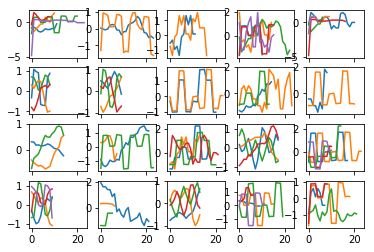

it		avg		std		max		time
1		-0.5084		0.074		-0.363909	4.7666
2		-0.5083		0.06		-0.363909	4.6781
3		-0.455		0.071		-0.324227	1.7178
4		-0.3342		0.076		-0.264832	2.3344


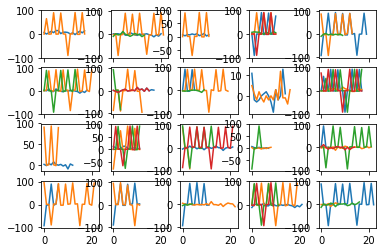

it		avg		std		max		time
1		-0.1944		0.178		-0.053432	4.3945
2		-0.1377		0.1		-0.053432	3.8101
3		-0.119		0.067		-0.053432	4.0138
4		-0.0858		0.047		-0.053432	3.45


In [6]:
print("standardized train and test data\n")
x_train, x_test = standardize_data(x_train, x_test)
genetic_extractor = GeneticExtractor(**genetic_options)
genetic_extrator_anglediff = GeneticExtractor(**genetic_options)
print_genetic_param(genetic_extractor)
genetic_extractor.fit(x_train, y_train)
genetic_extrator_anglediff.fit(x_train_anglediff,y_train)

In [11]:
distances_train = genetic_extractor.transform(x_train)
distances_test = genetic_extractor.transform(x_test)

distances_train_anglediff = genetic_extrator_anglediff.transform(x_train_anglediff)
distances_test_anglediff= genetic_extrator_anglediff.transform(x_test_anglediff)

mixed_distances_train = np.concatenate((distances_train,distances_train_anglediff),axis=1)
mixed_distances_test = np.concatenate((distances_test,distances_test_anglediff),axis=1) 
lr = LogisticRegression()
lr.fit(mixed_distances_train, y_train)

# Print the accuracy score on the test set
accuracy_result = accuracy_score(y_test, lr.predict(mixed_distances_test))
print('Accuracy = {}'.format(accuracy_result))

Accuracy = 1.0


In [ ]:
lr.predict(distances_test)

In [ ]:
lr.predict_proba(distances_test)